In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, roc_curve, auc
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import label_binarize

In [69]:
data = pd.read_csv("../Assignment 1/Wine_Test_02_6_8_red.csv")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.5,0.28,0.56,1.8,0.092,35.0,103.0,0.9969,3.30,0.75,10.5,2
1,7.9,0.32,0.51,1.8,0.341,17.0,56.0,0.9969,3.04,1.08,9.2,1
2,7.6,0.39,0.31,2.3,0.082,23.0,71.0,0.9982,3.52,0.65,9.7,1
3,8.1,0.38,0.28,2.1,0.066,13.0,30.0,0.9968,3.23,0.73,9.7,2
4,7.3,0.45,0.36,5.9,0.074,12.0,87.0,0.9978,3.33,0.83,10.5,1


## Data preprocessing

In [70]:
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

we can see that there is no null values

In [71]:
data["quality"].value_counts()

quality
1    272
2    132
0     38
Name: count, dtype: int64

here we notice that there is class imbalance

Training with Oversampling minority classes using SMTE algorithm since class imbalance will heavily impact knn performance

In [72]:
def overSample(data: pd.DataFrame):

    X = data.drop('quality', axis=1)
    y = data['quality']

    # training without randomstate to get random samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)
    
    return X_res, X_test, y_res, y_test

In [73]:
len(list(range(3, 70, 2)))

34

## Method 1

In [74]:
accuracy = []

for i in range(5):
    iter_accuracy = []
    for j in range(3, 70, 2):
        X_res, X_test, y_res, y_test = overSample(data)
        model = KNeighborsClassifier(n_neighbors=j, metric="euclidean", algorithm="ball_tree").fit(X_res, y_res)
        acc = mean_absolute_error(model.predict(X_test), y_test)
        iter_accuracy.append(acc)
    accuracy.append(iter_accuracy)

accuracy = np.array(accuracy)

In [75]:
avg_accuracy = np.zeros((1, accuracy.shape[1]))
avg_accuracy = np.average(accuracy, axis=0)

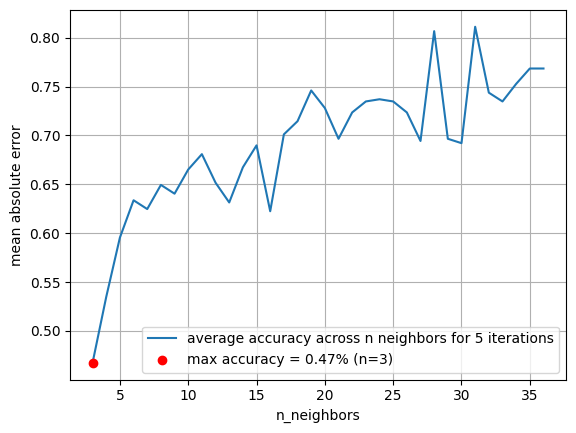

In [76]:
plt.plot(np.array(range(len(avg_accuracy))) + 3, avg_accuracy, label="average accuracy across n neighbors for 5 iterations"),
plt.scatter(np.argmin(np.array(range(len(avg_accuracy)))) + 3, min(avg_accuracy), c="red", zorder=100, label=f"max accuracy = {np.round(min(avg_accuracy), 2)}% (n={np.argmin(np.array(range(len(avg_accuracy)))) + 3})")
plt.xlabel("n_neighbors"), plt.ylabel("mean absolute error")
plt.grid()
plt.legend()

In [82]:
n_value = np.argmin(np.array(range(len(avg_accuracy)))) + 3

accuracy = []

for i in range(5):
    X_res, X_test, y_res, y_test = overSample(data)
    model = KNeighborsClassifier(n_neighbors=n_value, metric="euclidean", algorithm="ball_tree").fit(X_res, y_res)
    acc = mean_absolute_error(model.predict(X_test), y_test)
    accuracy.append(iter_accuracy)

accuracy = np.array(accuracy)
print(f"average accuracy: {round(np.mean(accuracy), 2) * 100}%")

average accuracy: 70.0%


#### Plot ROC curves for One Iteration

In [110]:
X = data.drop('quality', axis=1)
y = label_binarize(data['quality'], classes=[0,1,2])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=n_value, metric="euclidean", algorithm="ball_tree")).fit(X_res, y_res)
y_score = model.predict_proba(X_test)

In [113]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


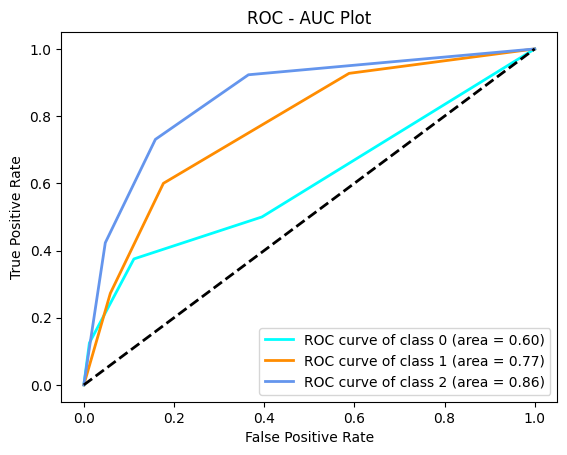

In [124]:
# Plot the ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
plt.title('ROC - AUC Plot')
plt.legend()
plt.show()


Higher the roc curve sticks to the top left of the plot, better the results. This is because we want the ratio between true positive to false positive rates to be as high as possible. In this case, we can assess the quality of training for indivisual classes. We see that for this iteration, class 2 has been understood by the model well, followed by class 1, and then class 0.

## Method 2

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': range(3, 70, 2),
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

accuracy = []

for i in range(5):
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=2, verbose=1)
    X_res, X_test, y_res, y_test = overSample(data)
    grid_search.fit(X_res, y_res)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_}")

    accuracy.append(grid_search.best_score_)


Fitting 2 folds for each of 272 candidates, totalling 544 fits
Best parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3}
Best cross-validation score: 0.7127796130250118
Fitting 2 folds for each of 272 candidates, totalling 544 fits
Best parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3}
Best cross-validation score: 0.7665030674846626
Fitting 2 folds for each of 272 candidates, totalling 544 fits
Best parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3}
Best cross-validation score: 0.7096743747050496
Fitting 2 folds for each of 272 candidates, totalling 544 fits
Best parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3}
Best cross-validation score: 0.7680840018876829
Fitting 2 folds for each of 272 candidates, totalling 544 fits
Best parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3}
Best cross-validation score: 0.7311986786219915


In [87]:
print(f"Mean Accuracy: {round(np.mean(accuracy), 2)*100}%")

Mean Accuracy: 74.0%


## Remarks

Mean accuracy of Method 1 = **70%**

Mean accuracy of Method 2 = **74%**

The difference in performance here is significant. This is because GridSearchCV automates the searching of the best hyperparameter combination which yields better results than hardcoding hyperparameters like it was done in method 1.